In [1]:
def confusion_matrix_article(Y,Z):
    print(type(Y),type(Z))
    
    
    np.seterr(divide='ignore', invalid='ignore')
    #print(np.diag(Y[0]))
    #print(sum(Z[0]))
    M = np.zeros((Y.shape[1],Y.shape[1]))
    W = np.zeros(Y.shape[1])
    print("M is ", M.shape)
    for i in range(len(Y)):
        if(np.allclose(Y[i],Z[i])):
            print(i, " - Y and Z are equal")
            C = np.diag(Y[i])
            print(C.shape)
        else:
            Y_complement_Z = np.where((Y[i]-Z[i])<0, 0, (Y[i]-Z[i]))
            print("|Yi\Zi| = ",sum(Y_complement_Z), ", shape = ", Y_complement_Z.shape)
            Z_complement_Y = np.where((Z[1]-Y[1])<0, 0, (Z[1]-Y[1]))
            print("|Zi\Yi| = ", sum(Z_complement_Y), ", shape = ", Y_complement_Z.shape)
            #Y_intersect_Z = (Y[i] & Z[i])
            
            for j in range(Y.shape[1]):
                if(Y[i][j]==Z[i][j]):
                    W[j]=Y[i][j]
                else:
                    W[j]=0
            
            Y_intersect_Z = W
            #### it will be a 861 x 861 matrix
            if (sum(Y_complement_Z)==0):  #if |Yi\Zi|=0
                # 𝐶=[(𝑌i∩𝑍i)⊗(𝑍i\𝑌i)+|𝑌i|⋅𝑑𝑖𝑎𝑔(𝑌i)]/|𝑍i|
                C1 = np.kron(Y_intersect_Z,Z_complement_Y)
                C2 = np.dot(sum(Y[i]),np.diag(Y[i]))
                C1 = C1.reshape(Y.shape[1],Y.shape[1]) 
                C = (C1+C2)/sum(Z[i])
            elif (sum(Z_complement_Y)==0):
                print("i = ", i)
                print("condiçao |Zi\Yi| =  0")
                print("kron:", np.kron(Y_complement_Z,Z[i]))
                C1 = np.kron(Y_complement_Z,Z[i])/sum(Z[i])
                if (np.isnan(np.min(C1))):
                    print("Tem nan em C1")
                    C1[np.isnan(C1)] = 0
                print("C1 = ", C1)
                C2 = np.diag(Z[i])
                if (np.isnan(np.min(C2))):
                    print("Tem nan em C1")
                    C2[np.isnan(C2)] = 0
                C1 = C1.reshape(Y.shape[1],Y.shape[1])
                C = C1+C2
            else:
                print("condiçao |Zi\Yi| diferente de 0")
                C1 = np.kron(Y_complement_Z,Z_complement_Y)/sum(Z_complement_Y)
                C2 = np.diag(Y_intersect_Z)
                C1 = C1.reshape(Y.shape[1],Y.shape[1])
                C = C1+C2
            print(C)
            M = M + C
    print("M = ", M)
    return M

In [2]:
def precision_matrix(M):
    #print(M.shape[0])
    rows = M.shape[0]
    columns = M.shape[1]
    sum_column = M.sum(axis=0)
    sum_row = M.sum(axis=1)
    precision_M = np.zeros((columns,rows))
    
    for i in range(columns):
        for j in range(rows):
            #print("sum_column[",i,"] = ",sum_column[i])
            #print("M[",j,"][",i,"] = ", M[j][i] )
            precision_M[j][i]= (M[j][i])/(sum_column[i])
            #print("precision_M[",j,"][",i,"] = ", precision_M[j][i] )
    
    if (np.isnan(np.min(precision_M))):
                    precision_M[np.isnan(precision_M)] = 0
    
    print("precision_M = ", precision_M)
    
    return precision_M

In [3]:
#!pip install scikit-multilearn -q

# para algoritmos adaptados usaremos KNN e Hierarquical ARAM NN
from skmultilearn.adapt import MLkNN, MLARAM
# para transformação de problemas usaremos Binary Relevance, Classifier Chain e Label Powerset
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss
import pandas as pd
import numpy as np
import sys
#np.set_printoptions(threshold=sys.maxsize)
from sklearn.naive_bayes import GaussianNB,MultinomialNB

## Load Train and Validation Dataframe (already one-hot encoded)

In [4]:
split_factor_file_train = "70_30"
split_factor_file_validation = "70_30"



df_train= pd.read_csv('/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Prepared_Data_for_ML_Input/PreparedData_train_BMI_Age_'+ split_factor_file_train + '.csv', sep=",")

df_validation = pd.read_csv('/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Prepared_Data_for_ML_Input/PreparedData_validation_BMI_Age_' + split_factor_file_validation + '.csv', sep=",")

In [5]:
df_train = df_train.drop(['Unnamed: 0'], axis=1)
print(df_train.shape)
df_train.head()

(768, 527)


MME  ADAM15  RTN4R  BTN2A1  SOD2  ROR1  KIT  LRPAP1  CXCL9  CLMP  ...  PRL  \
0    0       0      0       0     0     0    0       0      0     0  ...    0   
1    0       0      0       0     0     0    0       0      0     0  ...    0   
2    0       0      0       0     0     0    0       0      0     0  ...    0   
3    0       0      0       0     0     0    0       0      0     0  ...    0   
4    0       0      0       0     0     0    0       0      0     0  ...    0   

   PTH1R  REG3A  RSPO1  RSPO3  SMOC2  TFPI2  TSHB  Age  BMI  
0      0      0      0      0      0      0     0    1    3  
1      0      0      0      0      0      0     0    1    3  
2      1      0      0      0      0      0     0    1    3  
3      0      0      0      0      0      0     1    1    3  
4      0      0      0      0      0      0     0    1    3  

[5 rows x 527 columns]

In [6]:
if(split_factor_file_train != "60_40"):
    df_validation = df_validation.drop(['Unnamed: 0'], axis=1)
else:
    df_validation = df_validation.drop(['Unnamed: 0'], axis=1) #60_40 
print(df_validation.shape)
df_validation.head()

(158, 527)


MME  ADAM15  RTN4R  BTN2A1  SOD2  ROR1  KIT  LRPAP1  CXCL9  CLMP  ...  \
0    0       0      0       0     0     0    0       0      0     0  ...   
1    0       0      0       0     0     0    0       0      0     0  ...   
2    0       0      0       0     0     0    0       0      0     0  ...   
3    0       0      0       0     0     0    0       0      0     0  ...   
4    0       0      0       0     0     0    0       0      0     0  ...   

   CFC1  NCAM1  SPOCK1  ITGA6  RSPO3  MMP7  KAZALD1  IGFBP7  Age  BMI  
0     0      0       0      0      0     0        0       1    2    2  
1     0      0       0      0      0     0        0       0    2    3  
2     0      0       0      0      0     0        0       0    2    4  
3     0      0       0      0      0     0        0       0    2    4  
4     0      0       0      0      0     0        0       0    2    4  

[5 rows x 527 columns]

### Importante que <i>df_validation</i> tenha as mesmas colunas de <i>df_train</i>

In [7]:
print(df_train.dtypes)
print(df_validation.dtypes)

MME       int64
ADAM15    int64
RTN4R     int64
BTN2A1    int64
SOD2      int64
          ...  
SMOC2     int64
TFPI2     int64
TSHB      int64
Age       int64
BMI       int64
Length: 527, dtype: object
MME        int64
ADAM15     int64
RTN4R      int64
BTN2A1     int64
SOD2       int64
           ...  
MMP7       int64
KAZALD1    int64
IGFBP7     int64
Age        int64
BMI        int64
Length: 527, dtype: object


## Treinamento

**Separação da classe e previsores**


In [8]:
df_train.iloc[:,-2:].values #generic features

array([[1, 3],
       [1, 3],
       [1, 3],
       ...,
       [3, 3],
       [3, 3],
       [3, 3]])

In [9]:
df_train.iloc[:,:-2].values #generic labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:


classe = df_train.iloc[:,:-2].values #generic labels # df_train.iloc[:,:852].values #labels
previsores =  df_train.iloc[:,-2:].values #generic features     df_train.iloc[:,852:854].values #features
display(classe)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
classe.shape

(768, 525)

In [12]:
display(previsores)

array([[1, 3],
       [1, 3],
       [1, 3],
       ...,
       [3, 3],
       [3, 3],
       [3, 3]])

In [13]:
previsores.shape

(768, 2)

**Divisão de treino e teste**

- X_train will be the *previsores*
- y_train will be the *classes*

In [14]:
X_train = previsores
y_train = classe

In [15]:
X_train, y_train

(array([[1, 3],
        [1, 3],
        [1, 3],
        ...,
        [3, 3],
        [3, 3],
        [3, 3]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [16]:
y_test = df_validation.iloc[:,:-2].values #labels
X_test = df_validation.iloc[:,-2:].values #features


#y_test = df_validation.iloc[:,:852].values #labels
#X_test = df_validation.iloc[:,852:854].values #features


### Table with scores from all models

In [17]:
df_model_scores = pd.DataFrame()

## Algoritmo Adaptado

### KNN - Funciona OK
### Fix para scikit_Multilearn em https://github.com/scikit-multilearn/scikit-multilearn/issues/230

In [18]:
#http://scikit.ml/api/skmultilearn.adapt.mlknn.html
#from sklearn.model_selection import GridSearchCV
#parameters = {'k': range(1,int(classe.shape[1]/3)), 's': [0.5, 0.7, 1.0]}
#score = 'f1_macro'

#knn = GridSearchCV(MLkNN(), parameters, scoring=score)
#knn.fit(X_train, y_train) 

#print (knn.best_params_, knn.best_score_)

In [19]:
%%time
knn = MLkNN(k=int(classe.shape[1]/3)) 
knn.fit(X_train, y_train) 

CPU times: user 14.6 s, sys: 28.7 ms, total: 14.6 s
Wall time: 14.6 s


MLkNN(k=175)

**Previsão com dados de teste**



In [20]:
previsto = knn.predict(X_test) 

# atenção na saída e motivo de não ser visualizada
previsto.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
#y_test is already ndarray
Z = previsto.toarray()
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  78
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  79
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  80
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  157
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


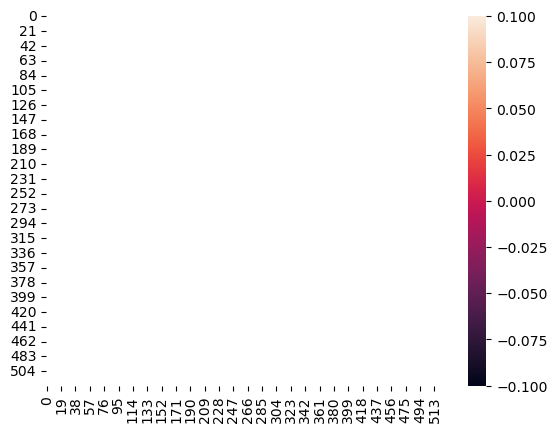

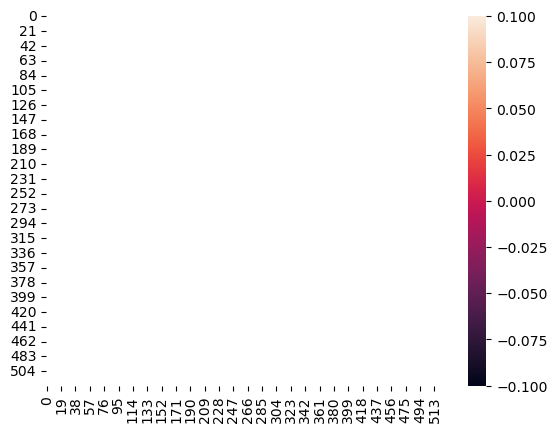

In [22]:
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Artigo

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

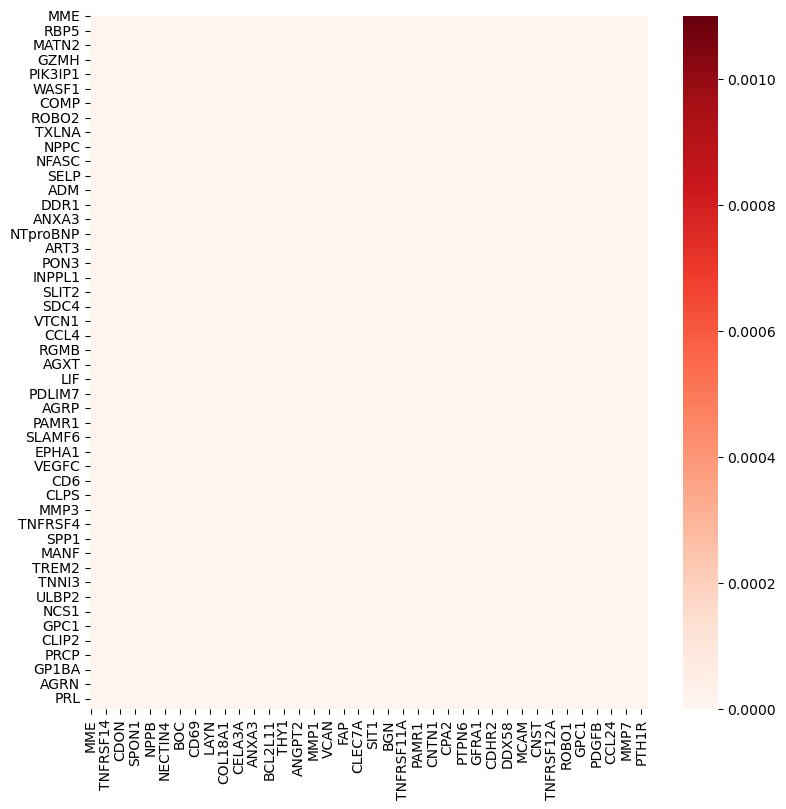

[]


<Figure size 640x480 with 0 Axes>

In [23]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/MLKNN/CM_MLKNN_" + split_factor_file_train + "_article.eps", transparent=True, format='png')
plt.show()
plt.clf()


#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/MLKNN/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 


**Hamming para avaliar performance**


In [24]:
# equivalent to print(hamming_loss(y_test, previsto.toarray())) 
print(hamming_loss(y_test, previsto)) 

0.0019047619047619048


<class 'scipy.sparse._lil.lil_matrix'>
0.0
0.7142857142857143
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[]
[]


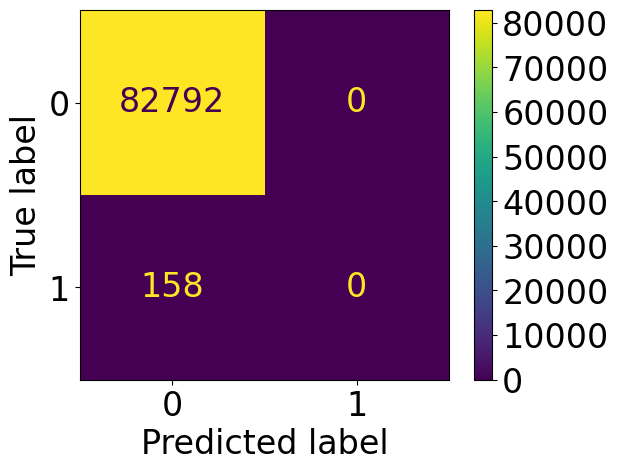

<Figure size 640x480 with 0 Axes>

In [25]:
# https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea 

from sklearn.metrics import multilabel_confusion_matrix
result = multilabel_confusion_matrix(y_test, previsto)[0]
result = multilabel_confusion_matrix(y_test, previsto)
result

print(type(previsto))

from sklearn.metrics import jaccard_score
print(jaccard_score(previsto,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsto, average='macro',zero_division=True))
print(jaccard_score(y_test,previsto, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsto, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsto))


matrices = multilabel_confusion_matrix(y_test, previsto)

cm = confusion_matrix(y_test.ravel(), (previsto.A).ravel())


# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
plt.rcParams.update({'font.size': 24})
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), (previsto.A).ravel())
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/MLKNN/CM_MLKNN_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)

        
#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/MLKNN/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
        

true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)




In the above code, tn, fp, fn, and tp represent the values from the confusion matrix. The index of the predicted label is determined by comparing the values of tn and fp. If tn is greater than fp, it indicates the label is predicted as negative (index 0), otherwise, it is predicted as positive (index 1).

At the end of this process, the predicted_labels list will contain the indexes of the predicted labels for each class. In the example given, predicted_labels will be [0, 1, 1], representing the predicted labels for each row.

Please note that the example provided assumes binary classification for each label. If you have more than two labels, you may need to modify the code accordingly.

- Para conseguir as proteinas, deve-se usar a formula de True Positives - aí pega-se a posição

### Precision, Recal, F-Score, Support

In [26]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1))

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'MLKNN', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsto),
                               'Prec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsto, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])
df_model_scores.head()

#df_model_scores = pd.DataFrame(columns = ["Model", "Proportion", "HL","Prec","Rec","F1","Jac"])

#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

Model Proportion        HL  Prec       Rec        F1       Jac
0  MLKNN      70_30  0.001905   1.0  0.714286  0.714286  0.714286

### F1-Score
https://medium.com/analytics-vidhya/metrics-for-multi-label-classification-49cc5aeba1c3

In [27]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsto))

0.7142857142857143


In [28]:
print(type(y_test), type(previsto))

<class 'numpy.ndarray'> <class 'scipy.sparse._lil.lil_matrix'>


### Hierarquical ARAM NN (Adaptive Resonance Associative Map Neural Network) - Funciona OK

In [29]:
%%time
aram = MLARAM()
aram.fit(X_train, y_train) 

CPU times: user 341 ms, sys: 161 ms, total: 502 ms
Wall time: 63.3 ms


MLARAM(neurons=[<skmultilearn.adapt.mlaram.Neuron object at 0x7fb1216239d0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb124ac5330>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb1215dbee0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb1014eecb0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb1017aa710>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121...
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb1216230d0>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121623130>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121621840>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121621990>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121621930>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121622b00>,
                <skmultilearn.adapt.mlaram.Neuron object at 0x7fb121621960>, ...])

**Previsão com dados de teste**

In [30]:
previsto = aram.predict(X_test) 
previsto

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
#y_test is already ndarray
#Z = previsto
#Y = y_test
#print(Y.shape, Z.shape)
#print(type(Y), type(Z))
#for z in Z:
#    print(z)

#confusion_matrix_article(Y,Z)


#y_test is already ndarray
Z = previsto
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)
type(precision_M)



(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05263158 0.05263158 0.05263158]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi

|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0

|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1.0 , shape =  (525,)
|Zi\Yi| =  19.0 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0

numpy.ndarray

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.006329113924050645 . Min value:  0.0
Max value:  0.

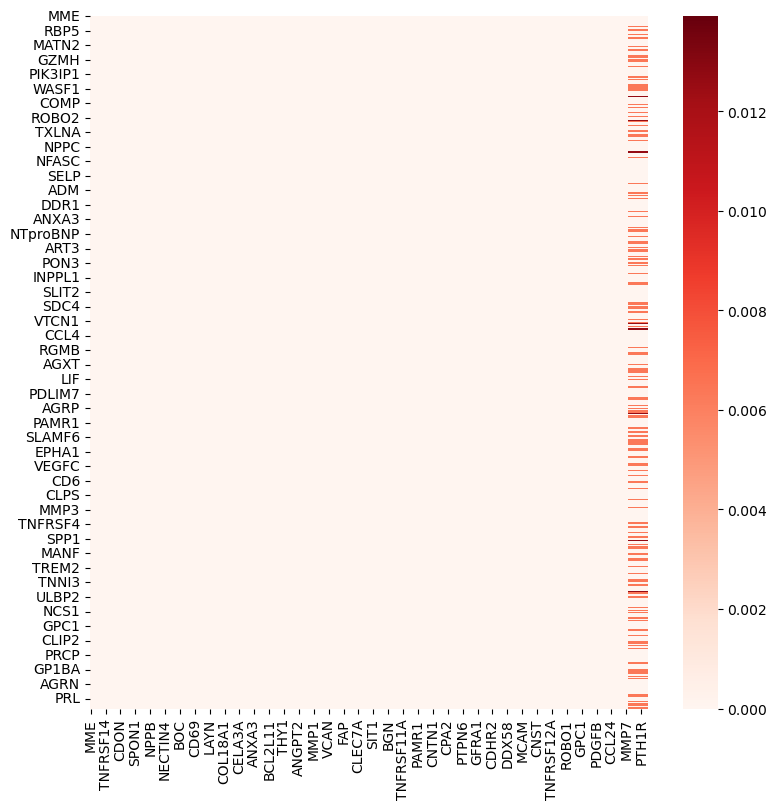

[8, 10, 11, 14, 16, 17, 23, 25, 26, 30, 31, 33, 34, 38, 46, 48, 52, 53, 54, 55, 56, 61, 67, 69, 73, 76, 79, 80, 83, 87, 90, 91, 94, 103, 107, 127, 134, 136, 138, 148, 152, 160, 162, 163, 167, 171, 172, 175, 177, 178, 182, 184, 187, 189, 195, 202, 203, 217, 218, 220, 221, 224, 230, 232, 233, 235, 237, 251, 255, 256, 264, 267, 268, 269, 270, 273, 275, 281, 289, 290, 295, 297, 299, 300, 301, 303, 304, 312, 315, 318, 321, 322, 323, 324, 328, 329, 334, 339, 340, 344, 348, 353, 358, 366, 372, 384, 387, 391, 394, 395, 397, 400, 402, 403, 407, 408, 411, 412, 417, 422, 427, 428, 431, 436, 437, 440, 448, 450, 452, 456, 458, 465, 469, 474, 475, 477, 479, 490, 495, 496, 497, 498, 500, 502, 514, 515, 519, 521, 522, 524]
CXCL9
DSG3
RBP5
TNFRSF14
LAIR1
CEACAM8
KITLG
CCDC80
ACP5
SPON2
NECTIN2
GZMH
PRSS8
NTRK2
FCN2
TIA1
SPINT2
DRAXIN
CXCL10
WASF1
NPPB
SIRPA
EGFL7
HSPG2
FKBP1B
ITGA11
KLK11
CCL23
ACTN4
SEMA4D
THBD
ADAM22
COX5B
ADAMTS15
ERBB2
ARHGAP25
TGFA
CNTN5
MMP10
CD209
ADAMTS16
YES1
CXCL16
HYOU1
TNFS

<Figure size 640x480 with 0 Axes>

In [32]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/HARAM/CM_HARAM_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/HARAM/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 
  

**Hamming para avaliar preformance**


In [33]:
print(hamming_loss(y_test, previsto)) 

0.006919831223628692


In [34]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       0.00      1.00      0.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [35]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsto))

0.6076190476190476


0.0
0.6076190476190476
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[156   1]
  [  1   0]]

 [[157   1]
  [  0   0]]

 [[156   1]
  [  1   0]]]
<class 'numpy.ndarray'>
525
[]
[]


Model Proportion        HL      Prec       Rec        F1       Jac
0  MLKNN      70_30  0.001905  1.000000  0.714286  0.714286  0.714286
0  HARAM      70_30  0.006920  0.855238  0.714286  0.607619  0.607619

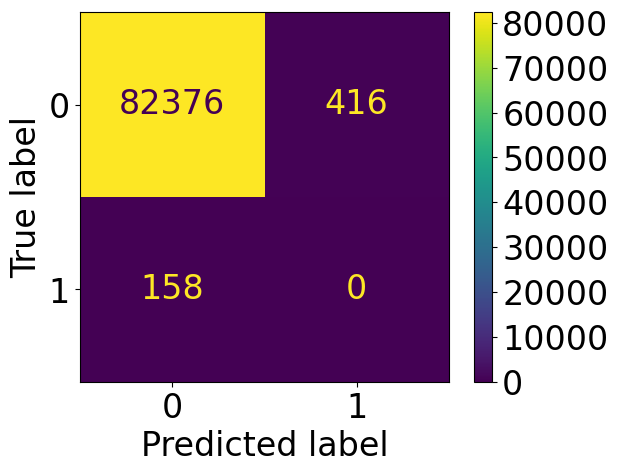

<Figure size 640x480 with 0 Axes>

In [36]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsto,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsto, average='macro',zero_division=True))
print(jaccard_score(y_test,previsto, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsto, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsto))

print(type(previsto))

matrices = multilabel_confusion_matrix(y_test, previsto)

cm = confusion_matrix(y_test.ravel(), previsto.ravel())

# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
plt.rcParams.update({'font.size': 24})
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsto.ravel())
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/HARAM/CM_HARAM_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/HARAM/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
        
true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)


#define rows to add
rows_to_append = pd.DataFrame([{'Model':'HARAM', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsto),
                               'Prec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsto, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsto, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

## Transformação de Problema

## Binary Relevance com Multinomial Naive Bayes

In [37]:
binary = BinaryRelevance(MultinomialNB())

#binary = BinaryRelevance(classifier = SVC())


In [38]:
%%time
binary.fit(X_train, y_train)
# https://stackoverflow.com/questions/67307405/how-to-resolve-valueerror-the-number-of-classes-has-to-be-greater-than-one-got 

CPU times: user 577 ms, sys: 147 ms, total: 724 ms
Wall time: 305 ms


BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [39]:
previsao = binary.predict(X_test)
print(hamming_loss(y_test, previsao))

0.0019047619047619048


In [40]:
previsao.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsao,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [42]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsto))

0.6076190476190476


0.0
0.7142857142857143
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[]
[]


Model Proportion        HL      Prec       Rec        F1  \
0             MLKNN      70_30  0.001905  1.000000  0.714286  0.714286   
0             HARAM      70_30  0.006920  0.855238  0.714286  0.607619   
0  BR_MultinomialNB      70_30  0.001905  1.000000  0.714286  0.714286   

        Jac  
0  0.714286  
0  0.607619  
0  0.714286

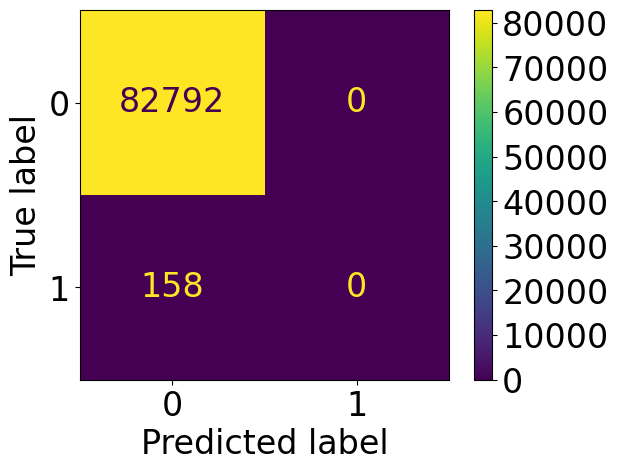

<Figure size 640x480 with 0 Axes>

In [43]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsao.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsao.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsao.A)

cm = confusion_matrix(y_test.ravel(), previsao.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsao.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_MultinomialNB/CM_BR_MultinomialNB_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_MultinomialNB/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 


true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)


#define rows to add
rows_to_append = pd.DataFrame([{'Model':'BR_MultinomialNB', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsao),
                               'Prec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsao, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  29
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  30
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  31
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  73
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  74
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  75
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  104
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  105
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  106
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  152
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  153
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  154
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0

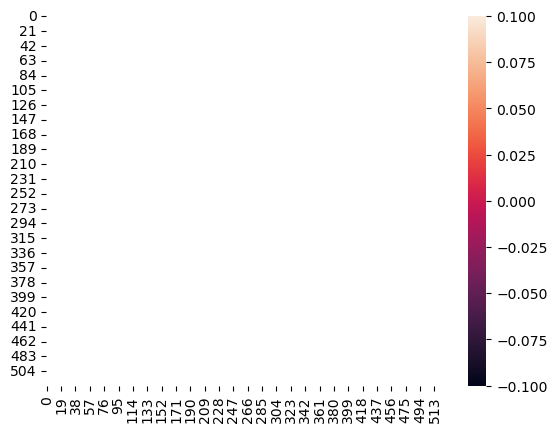

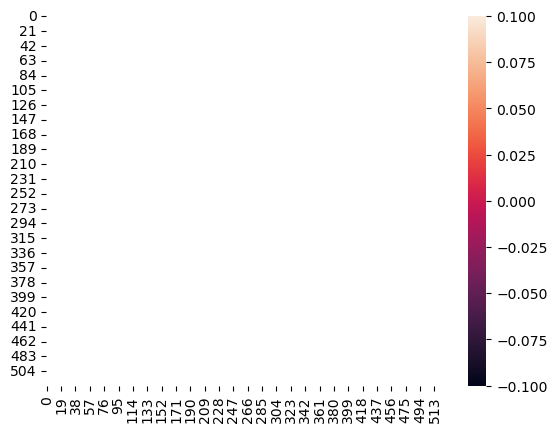

In [44]:
#y_test is already ndarray
Z = previsao.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

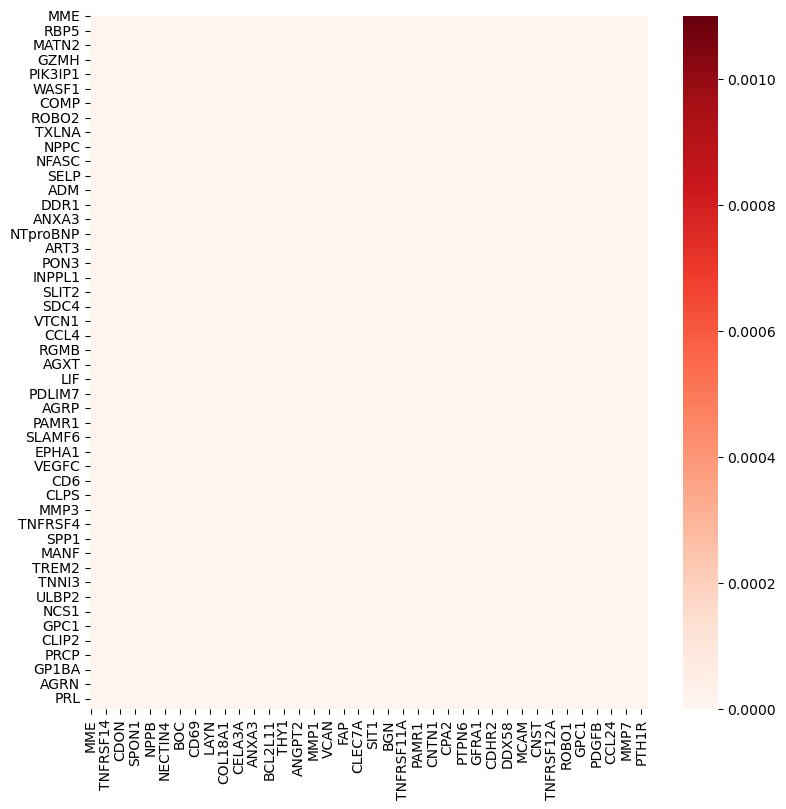

[]


<Figure size 640x480 with 0 Axes>

In [45]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_MultinomialNB/CM_BR_MultinomialNB_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_MultinomialNB/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### Label Powerset with GradientBoostingClassifier

In [46]:
#binary = BinaryRelevance(GaussianNB()) #Agora com Gaussian NB

from sklearn.ensemble import GradientBoostingClassifier
#binary = BinaryRelevance(GaussianNB()) #Agora com Gaussian NB
#binary = BinaryRelevance(BernoulliNB())
#binary = BinaryRelevance(GradientBoostingClassifier())
binary = LabelPowerset(GradientBoostingClassifier())

In [47]:
%%time
binary.fit(X_train, y_train)

CPU times: user 1min 48s, sys: 506 ms, total: 1min 48s
Wall time: 1min 48s


LabelPowerset(classifier=GradientBoostingClassifier(),
              require_dense=[True, True])

In [48]:
previsao = binary.predict(X_test)

In [49]:
print(hamming_loss(y_test, previsao))

0.00378541289933695


In [50]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsao,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [51]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsao))

0.7085963274198569


0.006329113924050633
0.7085839598997494
4.1638907395069954e-05
0.0031746031746031746
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[268]
TNF
[268]


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584

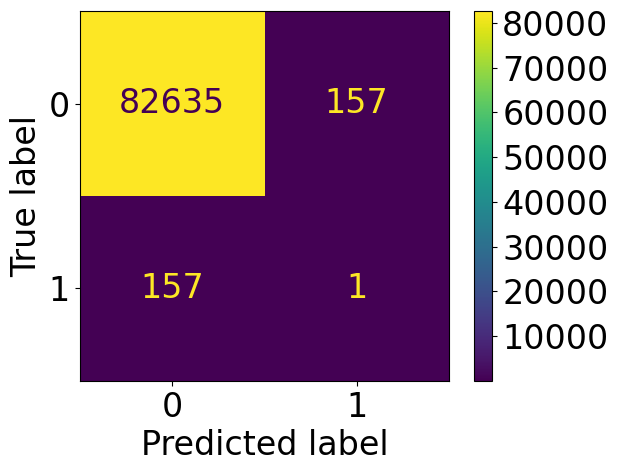

<Figure size 640x480 with 0 Axes>

In [52]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsao.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsao.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsao.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsao.A)

cm = confusion_matrix(y_test.ravel(), previsao.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsao.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_GaussianNB/CM_BR_GaussianNB_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_GaussianNB/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 
        
        
true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'Label Powerset GradientBooster', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsao),
                               'Prec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsao, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsao, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0


precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


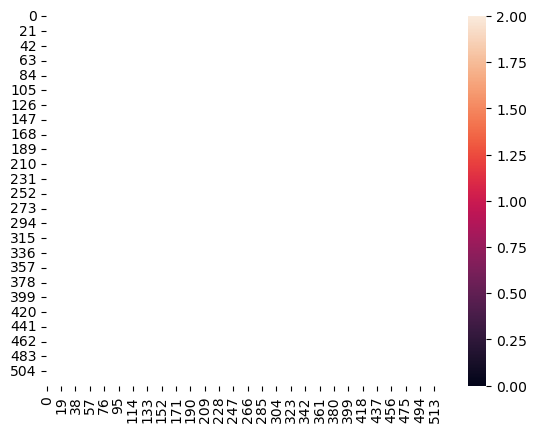

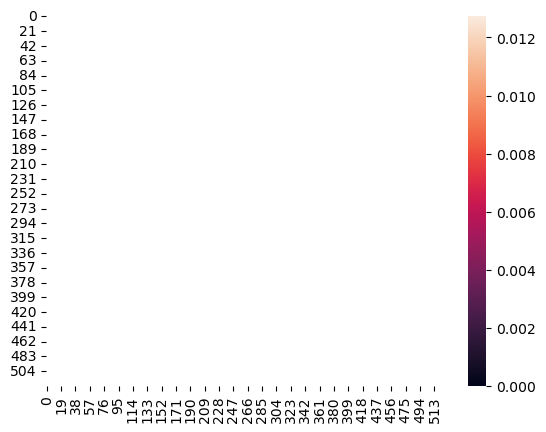

In [53]:
#y_test is already ndarray
Z = previsao.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.

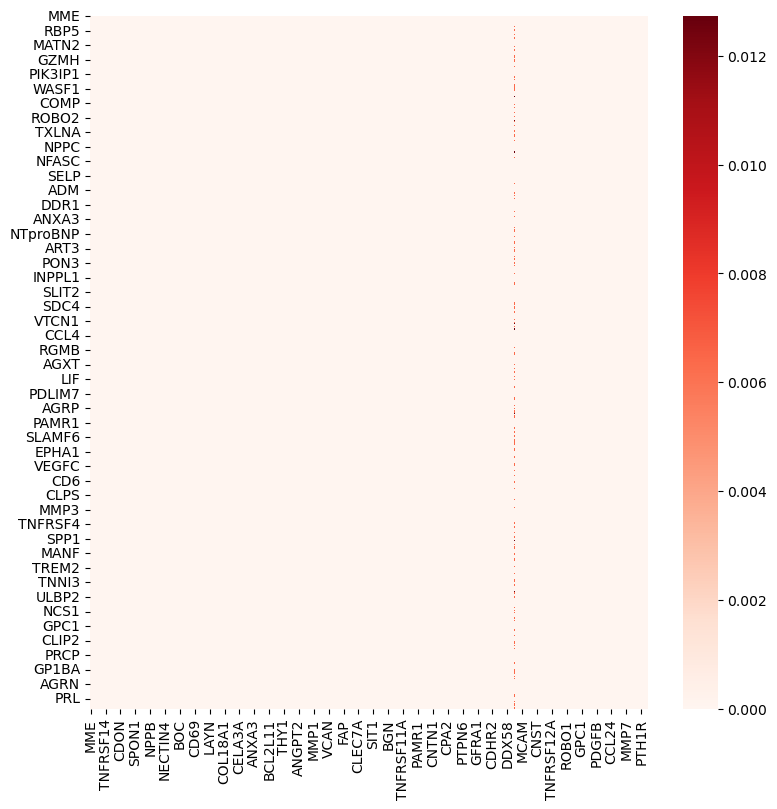

[8, 10, 11, 14, 16, 17, 23, 25, 26, 30, 31, 33, 34, 38, 46, 48, 52, 53, 54, 55, 56, 61, 67, 69, 73, 76, 79, 80, 83, 87, 90, 91, 94, 103, 107, 127, 134, 136, 138, 148, 152, 160, 162, 163, 167, 171, 172, 175, 177, 178, 182, 184, 187, 189, 195, 202, 203, 217, 218, 220, 221, 224, 230, 232, 233, 235, 237, 251, 255, 256, 264, 267, 269, 270, 273, 275, 281, 289, 290, 295, 297, 299, 300, 301, 303, 304, 312, 315, 318, 321, 322, 323, 324, 328, 329, 334, 339, 340, 344, 348, 353, 358, 366, 372, 384, 387, 391, 394, 395, 397, 400, 402, 403, 407, 408, 411, 412, 417, 422, 427, 428, 431, 436, 437, 440, 448, 450, 452, 456, 458, 465, 469, 474, 475, 477, 479, 490, 495, 496, 497, 498, 500, 502, 514, 515, 519, 521, 522, 524]
CXCL9
DSG3
RBP5
TNFRSF14
LAIR1
CEACAM8
KITLG
CCDC80
ACP5
SPON2
NECTIN2
GZMH
PRSS8
NTRK2
FCN2
TIA1
SPINT2
DRAXIN
CXCL10
WASF1
NPPB
SIRPA
EGFL7
HSPG2
FKBP1B
ITGA11
KLK11
CCL23
ACTN4
SEMA4D
THBD
ADAM22
COX5B
ADAMTS15
ERBB2
ARHGAP25
TGFA
CNTN5
MMP10
CD209
ADAMTS16
YES1
CXCL16
HYOU1
TNFSF12
C

<Figure size 640x480 with 0 Axes>

In [54]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_GaussianNB/CM_BR_GaussianNB_" + split_factor_file_train + "_article.eps", transparent=True, format='png')
plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_GaussianNB/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### Classifier Chain

In [55]:
%%time
#chain = ClassifierChain(classifier = MultinomialNB())
#chain.fit(X_train, y_train)
#previsoes = chain.predict(X_test)
#print(hamming_loss(y_test,previsoes))
from sklearn.tree import ExtraTreeClassifier
chain = ClassifierChain(classifier = ExtraTreeClassifier())
chain.fit(X_train, y_train)
previsoes = chain.predict(X_test)
print(hamming_loss(y_test,previsoes))

0.0038095238095238095
CPU times: user 1.07 s, sys: 7.69 ms, total: 1.07 s
Wall time: 1.07 s


In [56]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsoes,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [57]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsoes))

0.7123809523809523


0.0
0.7123809523809523
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[]
[]


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381

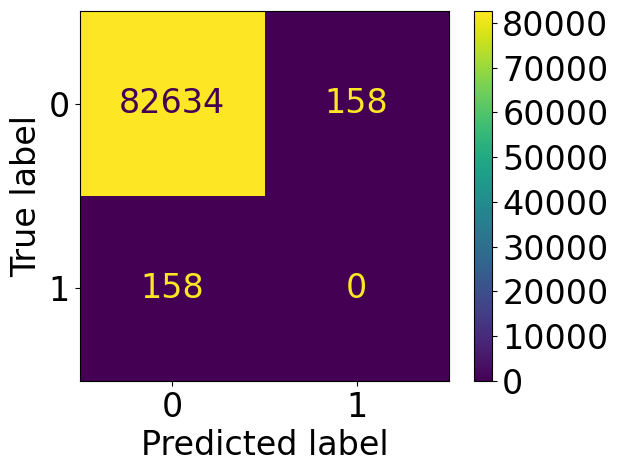

<Figure size 640x480 with 0 Axes>

In [58]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsoes.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsoes.A)

cm = confusion_matrix(y_test.ravel(), previsoes.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsoes.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/ClassifierChains/CM_ClassifierChains_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()





num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/ClassifierChains/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 
true_positive_indices = np.where(matrices[:, 1, 1] == 1)[0]
print(true_positive_indices)


#define rows to add
rows_to_append = pd.DataFrame([{'Model':'ClassifierChain', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsoes),
                               'Prec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsoes, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()




In [59]:
#             Predicted
#             0       1
# Actual 0   TN      FP
#        1   FN      TP


- TN (True Negative): The number of correctly predicted negative instances.
- FP (False Positive): The number of incorrectly predicted positive instances.
- FN (False Negative): The number of incorrectly predicted negative instances.
- TP (True Positive): The number of correctly predicted positive instances.

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0


precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


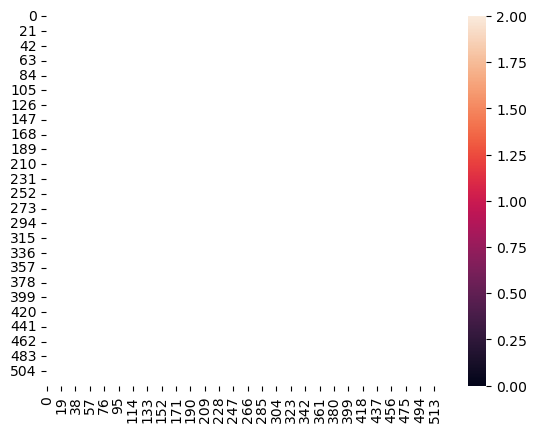

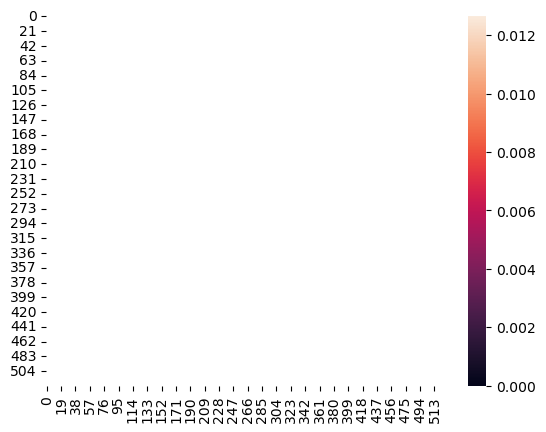

In [60]:
#y_test is already ndarray
Z = previsoes.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.006329113924050633 . Min value:  0.0
Max value:  0.

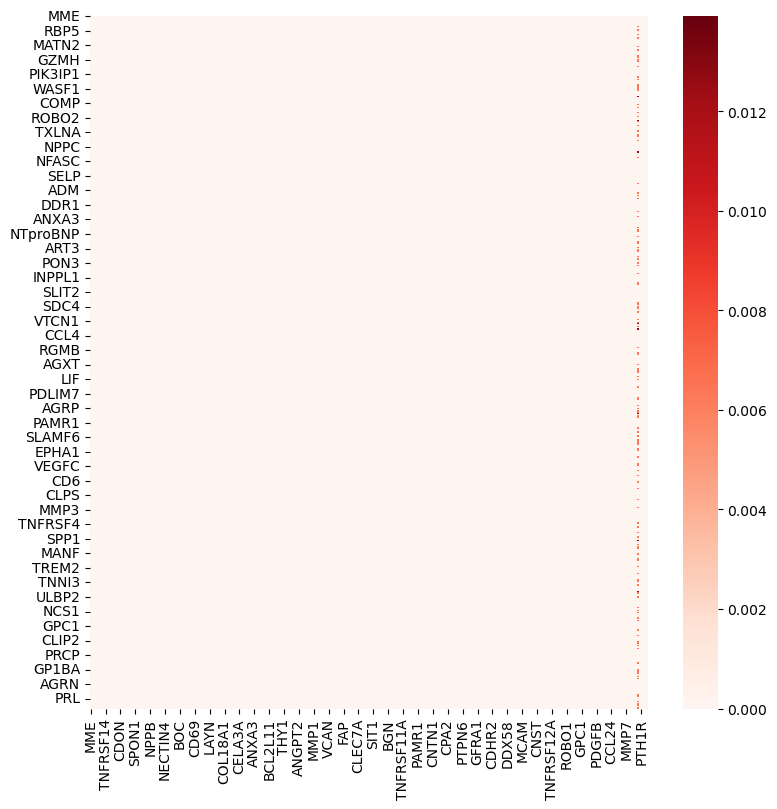

[8, 10, 11, 14, 16, 17, 23, 25, 26, 30, 31, 33, 34, 38, 46, 48, 52, 53, 54, 55, 56, 61, 67, 69, 73, 76, 79, 80, 83, 87, 90, 91, 94, 103, 107, 127, 134, 136, 138, 148, 152, 160, 162, 163, 167, 171, 172, 175, 177, 178, 182, 184, 187, 189, 195, 202, 203, 217, 218, 220, 221, 224, 230, 232, 233, 235, 237, 251, 255, 256, 264, 267, 268, 269, 270, 273, 275, 281, 289, 290, 295, 297, 299, 300, 301, 303, 304, 312, 315, 318, 321, 322, 323, 324, 328, 329, 334, 339, 340, 344, 348, 353, 358, 366, 372, 384, 387, 391, 394, 395, 397, 400, 402, 403, 407, 408, 411, 412, 417, 422, 427, 428, 431, 436, 437, 440, 448, 450, 452, 456, 458, 465, 469, 474, 475, 477, 479, 490, 495, 496, 497, 498, 500, 502, 514, 515, 519, 521, 522, 524]
CXCL9
DSG3
RBP5
TNFRSF14
LAIR1
CEACAM8
KITLG
CCDC80
ACP5
SPON2
NECTIN2
GZMH
PRSS8
NTRK2
FCN2
TIA1
SPINT2
DRAXIN
CXCL10
WASF1
NPPB
SIRPA
EGFL7
HSPG2
FKBP1B
ITGA11
KLK11
CCL23
ACTN4
SEMA4D
THBD
ADAM22
COX5B
ADAMTS15
ERBB2
ARHGAP25
TGFA
CNTN5
MMP10
CD209
ADAMTS16
YES1
CXCL16
HYOU1
TNFS

<Figure size 640x480 with 0 Axes>

In [61]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/ClassifierChains/CM_ClassifierChains_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/ClassifierChains/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### Label PowerSet - Funciona OK

In [62]:
%%time
label = LabelPowerset(classifier = SVC())
label.fit(X_train, y_train)
previsoes = label.predict(X_test)
print(hamming_loss(y_test,previsoes))

0.00378541289933695
CPU times: user 382 ms, sys: 3.06 ms, total: 385 ms
Wall time: 384 ms


In [63]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, previsoes,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [64]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, previsoes))

0.7124079702803108


0.006329113924050633
0.7123945578231292
4.5207956600361664e-05
0.0031746031746031746
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[268]
TNF


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   
0              Label Powerset SVC      70_30  0.003785  0.996204  0.716190   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381  
0  0.712408  0.712395

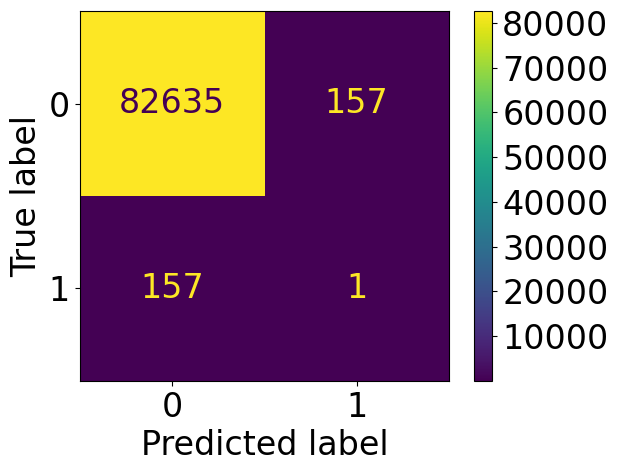

<Figure size 640x480 with 0 Axes>

In [65]:
from sklearn.metrics import jaccard_score
print(jaccard_score(previsoes.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='macro',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,previsoes.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, previsoes.A)

cm = confusion_matrix(y_test.ravel(), previsoes.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), previsoes.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/LabelPowerSet/CM_LabelPowerSet_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/LabelPowerSet/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'Label Powerset SVC', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, previsoes),
                               'Prec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, previsoes, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,previsoes, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head(20)

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  1 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0


precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


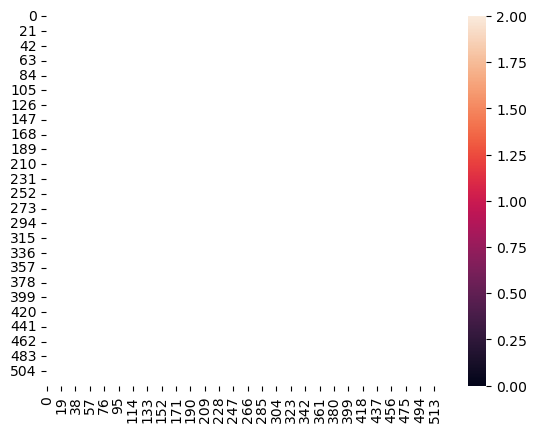

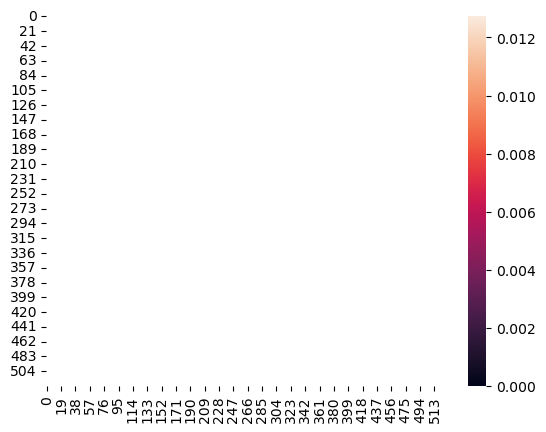

In [66]:
#y_test is already ndarray
Z = previsoes.A
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.006369426751592357 . Min value:  0.0
Max value:  0.

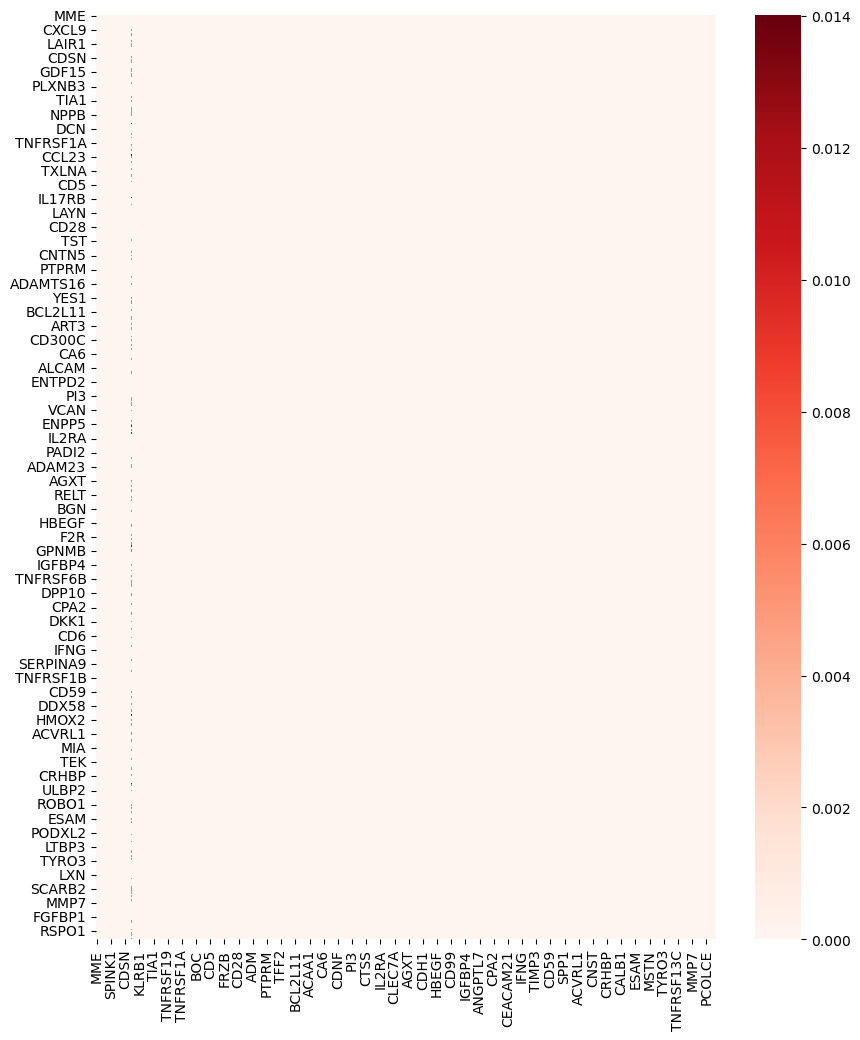

[8, 10, 11, 14, 16, 17, 23, 25, 26, 30, 31, 33, 34, 38, 46, 48, 52, 53, 54, 55, 56, 61, 67, 69, 73, 76, 79, 80, 83, 87, 90, 91, 94, 103, 107, 127, 134, 136, 138, 148, 152, 160, 162, 163, 167, 171, 172, 175, 177, 178, 182, 184, 187, 189, 195, 202, 203, 217, 218, 220, 221, 224, 230, 232, 233, 235, 237, 251, 255, 256, 264, 267, 269, 270, 273, 275, 281, 289, 290, 295, 297, 299, 300, 301, 303, 304, 312, 315, 318, 321, 322, 323, 324, 328, 329, 334, 339, 340, 344, 348, 353, 358, 366, 372, 384, 387, 391, 394, 395, 397, 400, 402, 403, 407, 408, 411, 412, 417, 422, 427, 428, 431, 436, 437, 440, 448, 450, 452, 456, 458, 465, 469, 474, 475, 477, 479, 490, 495, 496, 497, 498, 500, 502, 514, 515, 519, 521, 522, 524]
CXCL9
DSG3
RBP5
TNFRSF14
LAIR1
CEACAM8
KITLG
CCDC80
ACP5
SPON2
NECTIN2
GZMH
PRSS8
NTRK2
FCN2
TIA1
SPINT2
DRAXIN
CXCL10
WASF1
NPPB
SIRPA
EGFL7
HSPG2
FKBP1B
ITGA11
KLK11
CCL23
ACTN4
SEMA4D
THBD
ADAM22
COX5B
ADAMTS15
ERBB2
ARHGAP25
TGFA
CNTN5
MMP10
CD209
ADAMTS16
YES1
CXCL16
HYOU1
TNFSF12
C

<Figure size 640x480 with 0 Axes>

In [67]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (10,12))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/LabelPowerSet/CM_LabelPowerSet_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/LabelPowerSet/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### RandomForest - Funciona OK

In [68]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf = clf.fit(X_train, y_train)

CPU times: user 3.45 s, sys: 149 ms, total: 3.6 s
Wall time: 2.13 s


In [69]:
#Test
predicted_labels = clf.predict(X_test)
print(hamming_loss(y_test,predicted_labels))
    

0.0019047619047619048


In [70]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predicted_labels,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [71]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, predicted_labels))

0.7142857142857143


0.0
0.7142857142857143
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[]


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381

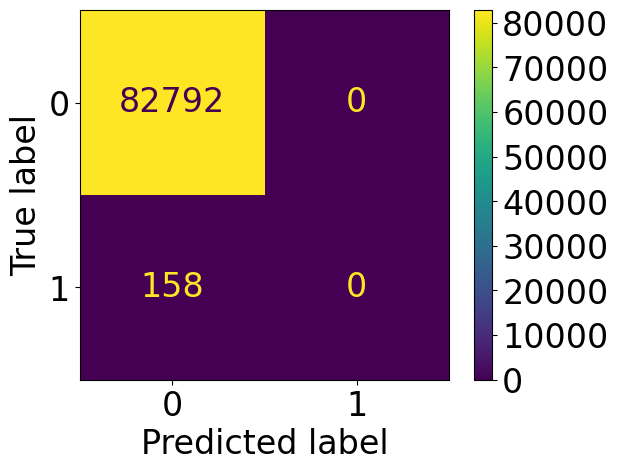

<Figure size 640x480 with 0 Axes>

In [72]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predicted_labels,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='macro',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='weighted',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, predicted_labels)

cm = confusion_matrix(y_test.ravel(), predicted_labels.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), predicted_labels.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RandomForest/CM_RandomForest_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RandomForest/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 
        
    
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'RandomForest', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predicted_labels),
                               'Prec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predicted_labels, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  76
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  77
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  78
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  102
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  103
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  104
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  157
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


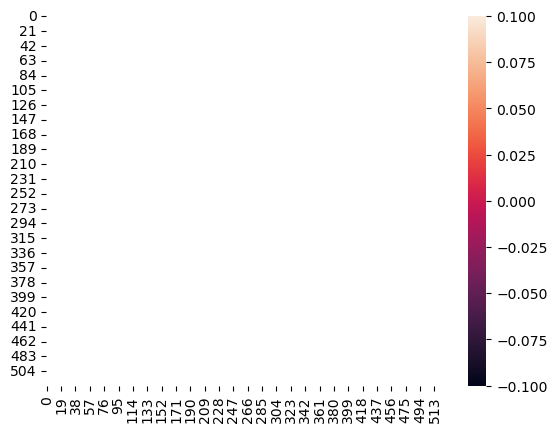

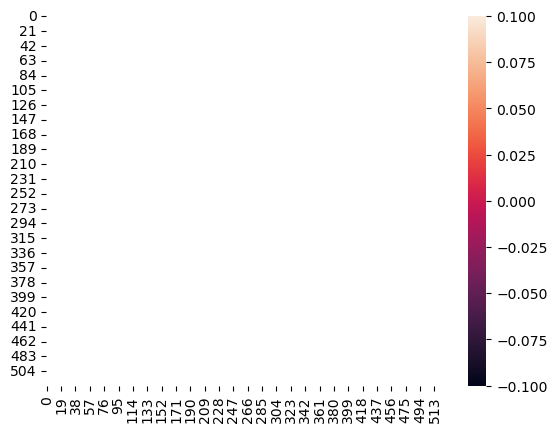

In [73]:
#y_test is already ndarray
Z = predicted_labels
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

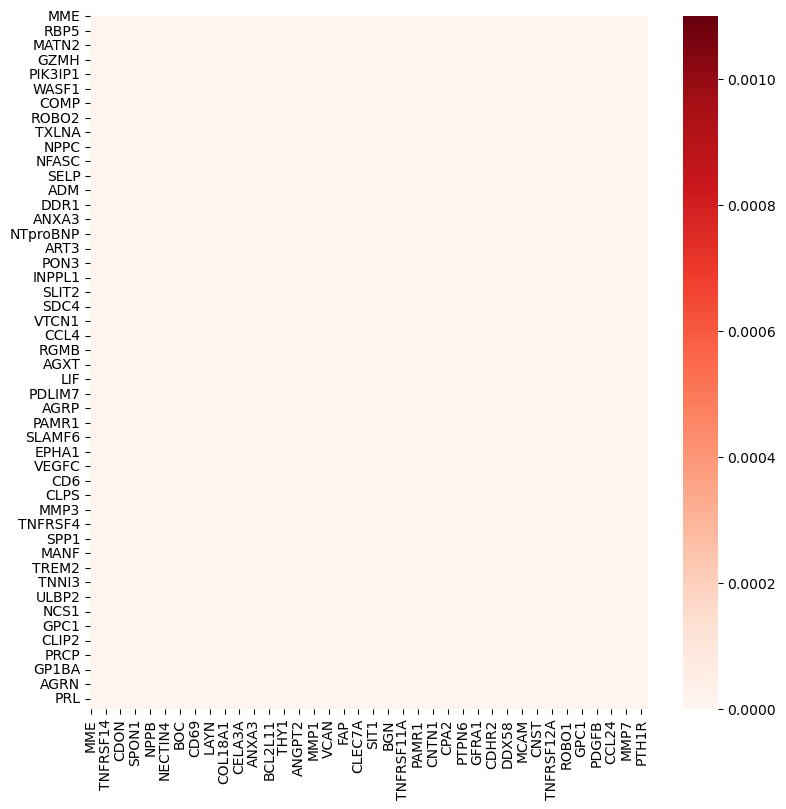

[]


<Figure size 640x480 with 0 Axes>

In [74]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RandomForest/CM_RandomForest_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RandomForest/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### Decision Tree

In [75]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(random_state=100)
clf = clf.fit(X_train, y_train)

CPU times: user 27.5 ms, sys: 2.12 ms, total: 29.7 ms
Wall time: 27.9 ms


In [76]:
#Test
predicted_labels = clf.predict(X_test)
print(hamming_loss(y_test,predicted_labels))

0.0019047619047619048


In [77]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predicted_labels,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))




              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [78]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, predicted_labels))

0.7142857142857143


0.0
0.7142857142857143
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
525
[]


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381

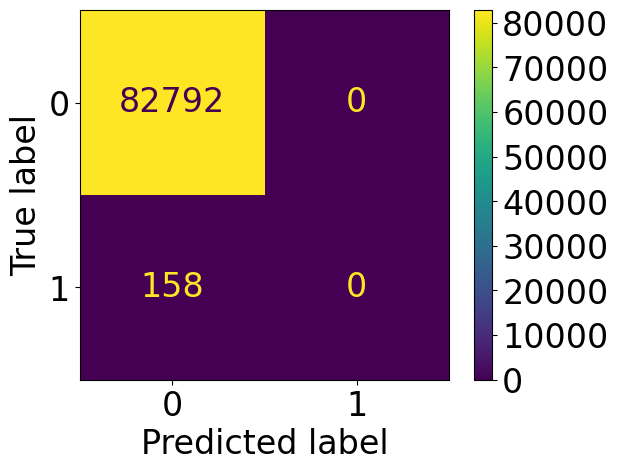

<Figure size 640x480 with 0 Axes>

In [79]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predicted_labels,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='macro',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='weighted',zero_division=True))
print(jaccard_score(y_test,predicted_labels, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, previsao))


matrices = multilabel_confusion_matrix(y_test, predicted_labels)

cm = confusion_matrix(y_test.ravel(), predicted_labels.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.ravel(), predicted_labels.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/DecisionTree/CM_DecisionTree_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()



num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/DecisionTree/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'DecisionTree', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predicted_labels),
                               'Prec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predicted_labels, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predicted_labels, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  75
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  76
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  77
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  104
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  105
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  106
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  156
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  157
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
preci

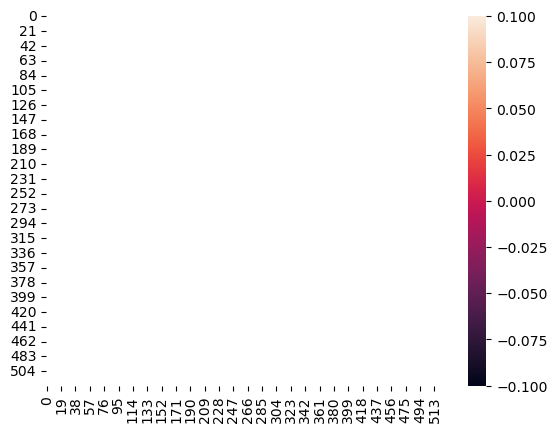

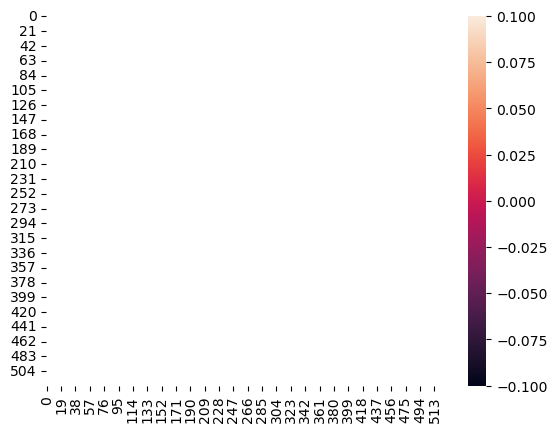

In [80]:
#y_test is already ndarray
Z = predicted_labels
print(Z.shape)
Y = y_test
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

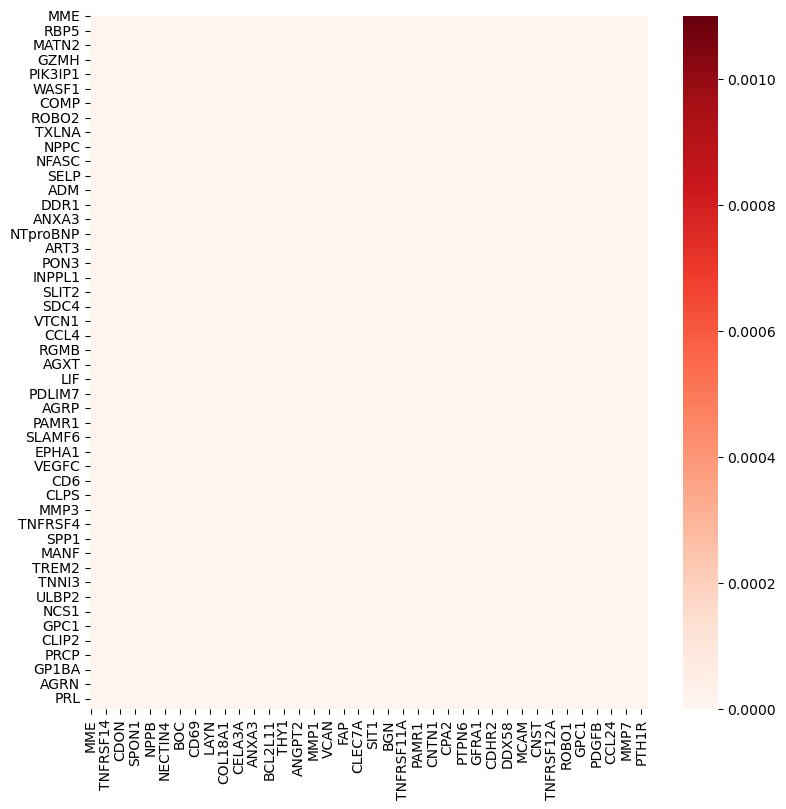

[]


<Figure size 640x480 with 0 Axes>

In [81]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/DecisionTree/CM_DecisionTree_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/DecisionTree/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### Support Vector Machine

In [82]:
%%time
from skmultilearn.adapt import MLTSVM
from scipy import sparse

classifier = MLTSVM(c_k = 2**-1)

X_train = sparse.csr_matrix(X_train)
y_train = sparse.csr_matrix(y_train)
y_test = sparse.csr_matrix(y_test)
print(type(X_train),type(y_train))
# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(hamming_loss(y_test,predictions))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
0.15316455696202533
CPU times: user 1min 5s, sys: 133 ms, total: 1min 5s
Wall time: 1min 5s


In [83]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predictions,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))


              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       0.00      1.00      0.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       0.00      1.00      0.00         0
        SOD2       0.00      1.00      0.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       0.01      1.00      0.01         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       0.00      1.00      0.00         0
    TNFRSF14       0.01      1.00      0.01         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

In [84]:
from sklearn.metrics import f1_score

def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "macro",zero_division=1)
    return f1


print(f1_sampled(y_test, predictions))

0.5395834494592392


0.0014892032762472078
0.5393174318984371
0.0008965300422749075
0.0015717092337917485
[[[158   0]
  [  0   0]]

 [[ 17 141]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[ 18 139]
  [  0   1]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
<class 'scipy.sparse._csr.csr_matrix'>
525
[11, 14, 34, 52, 53, 69, 134, 178, 230, 268, 281, 300, 315, 328, 329, 395, 474, 475, 490, 522]
RBP5
TNFRSF14
PRSS8
SPINT2
DRAXIN
HSPG2
TGFA
CXADR
ADGRG2
TNF
REG1A
CD99
CCL13
DPP10
COLEC12
COL1A1
CD83
REG1B
CCL24
SMOC2


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381

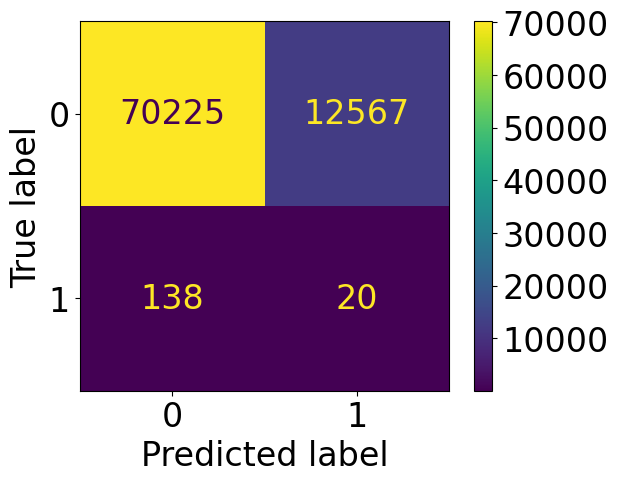

<Figure size 640x480 with 0 Axes>

In [85]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predictions,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predictions, average='macro',zero_division=True))
print(jaccard_score(y_test,predictions, average='weighted',zero_division=True))
print(jaccard_score(y_test,predictions, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, predictions))


matrices = multilabel_confusion_matrix(y_test, predictions)

print(type(y_test))

cm = confusion_matrix(y_test.A.ravel(), predictions.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.A.ravel(), predictions.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/SVM/CM_SVM_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()




num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/SVM/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 
        
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'SVM', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predictions),
                               'Prec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predictions, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01176471 0.         ... 0.         0.         0.        ]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente d

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  85 , shape =  (525,)
condiçao |Zi\Yi| diferente d

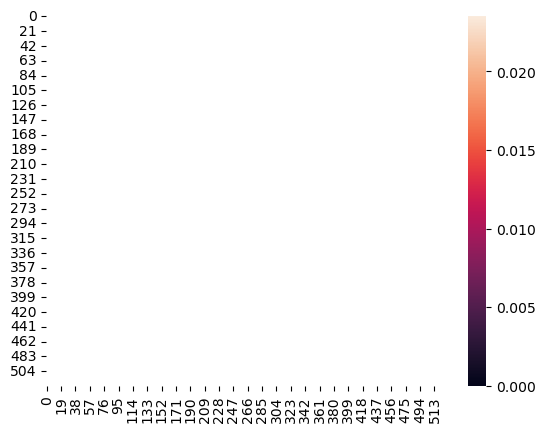

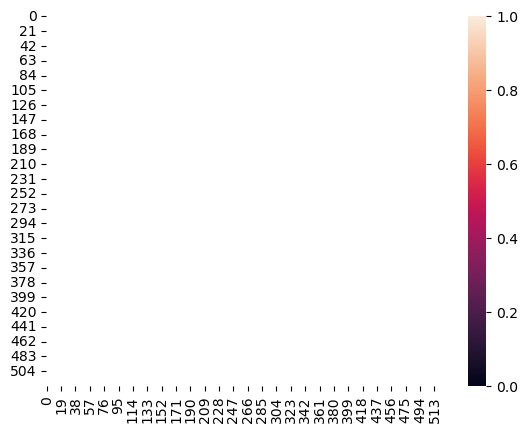

In [86]:
#y_test is already ndarray
Z = predictions
print(Z.shape)
Y = y_test.A
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.006329113924050647 . Min value:  0.0
Max value:  0.006329113924050647 . Min value:  0.0
Max value:  0.006329113924050647 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.012578616352201286 . Min value:  0.0
Max value:  0.

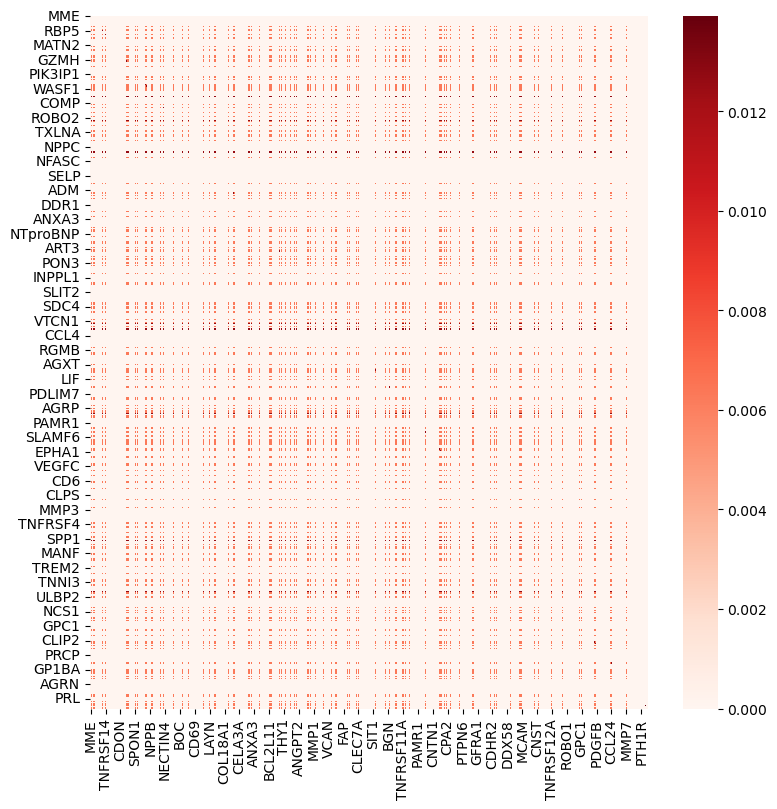

[8, 10, 11, 14, 16, 17, 23, 25, 26, 30, 31, 33, 34, 38, 46, 48, 52, 53, 54, 55, 56, 61, 67, 69, 73, 76, 79, 80, 83, 87, 90, 91, 94, 103, 107, 127, 134, 136, 138, 148, 152, 160, 162, 163, 167, 171, 172, 175, 177, 178, 182, 184, 187, 189, 195, 202, 203, 217, 218, 220, 221, 224, 230, 232, 233, 235, 237, 251, 255, 256, 264, 267, 268, 269, 270, 273, 275, 281, 289, 290, 295, 297, 299, 300, 301, 303, 304, 312, 315, 318, 321, 322, 323, 324, 328, 329, 334, 339, 340, 344, 348, 353, 358, 366, 372, 384, 387, 391, 394, 395, 397, 400, 402, 403, 407, 408, 411, 412, 417, 422, 427, 428, 431, 436, 437, 440, 448, 450, 452, 456, 458, 465, 469, 474, 475, 477, 479, 490, 495, 496, 497, 498, 500, 502, 514, 515, 519, 521, 522, 524]
CXCL9
DSG3
RBP5
TNFRSF14
LAIR1
CEACAM8
KITLG
CCDC80
ACP5
SPON2
NECTIN2
GZMH
PRSS8
NTRK2
FCN2
TIA1
SPINT2
DRAXIN
CXCL10
WASF1
NPPB
SIRPA
EGFL7
HSPG2
FKBP1B
ITGA11
KLK11
CCL23
ACTN4
SEMA4D
THBD
ADAM22
COX5B
ADAMTS15
ERBB2
ARHGAP25
TGFA
CNTN5
MMP10
CD209
ADAMTS16
YES1
CXCL16
HYOU1
TNFS

<Figure size 640x480 with 0 Axes>

In [87]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/SVM/CM_SVM_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/SVM/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### Binary Relevance kNN

In [88]:
%%time
from skmultilearn.adapt import BRkNNaClassifier

classifier = BRkNNaClassifier(k=int(classe.shape[1]/3))

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(hamming_loss(y_test,predictions))

0.0019047619047619048
CPU times: user 18.2 ms, sys: 1.24 ms, total: 19.4 ms
Wall time: 18.8 ms


In [89]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predictions,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1))


#print(precision_recall_fscore_support(y_test, previsto, average='micro',zero_division=1))

#print(precision_recall_fscore_support(y_test, previsto, average='weighted',zero_division=1))


              precision    recall  f1-score   support

         MME       1.00      1.00      1.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       1.00      1.00      1.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       1.00      1.00      1.00         0
         KIT       1.00      1.00      1.00         0
      LRPAP1       1.00      1.00      1.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       1.00      1.00      1.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       1.00      1.00      1.00         0
       LAIR1       1.00      0.00      0.00         1
     CEACAM8       1.00    

0.0
0.7142857142857143
0.0
0.0
[[[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[158   0]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
<class 'scipy.sparse._csr.csr_matrix'>
525
[]


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381

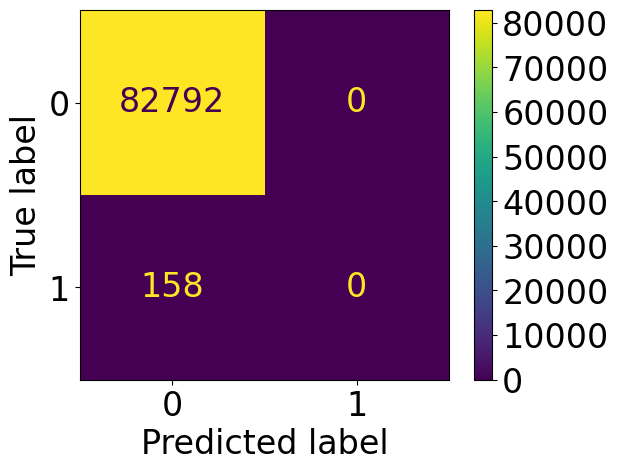

<Figure size 640x480 with 0 Axes>

In [90]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predictions.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predictions.A, average='macro',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, predictions.A))


matrices = multilabel_confusion_matrix(y_test, predictions)

print(type(y_test))

cm = confusion_matrix(y_test.A.ravel(), predictions.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.A.ravel(), predictions.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_kNN/CM_BR_kNN_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()


num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_kNN/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 
#define rows to add
rows_to_append = pd.DataFrame([{'Model':'BR_kNN', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predictions),
                               'Prec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predictions, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()
        

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  0
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  1
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  2
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  30
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  31
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  32
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  73
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  74
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  75
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0

Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  107
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  108
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  109
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  150
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  151
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  0 , shape =  (525,)
i =  152
condiçao |Zi\Yi| =  0
kron: [0 0 0 ... 0 0 0]
Tem nan em C1
C1 =  [0. 0. 0. ... 0. 0. 0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

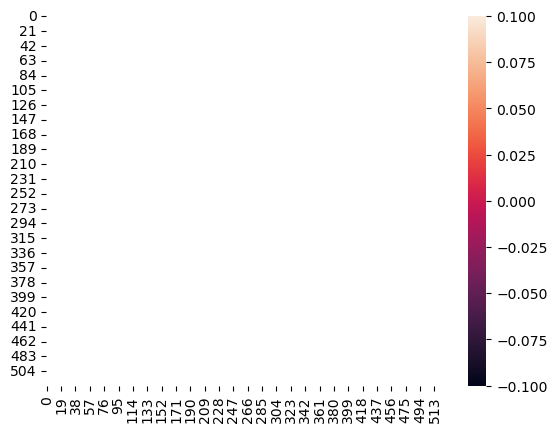

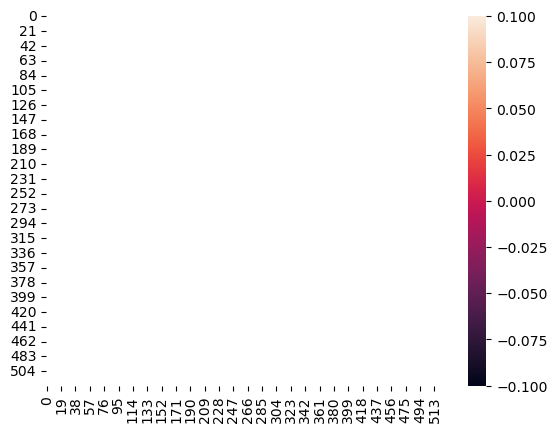

In [91]:
#y_test is already ndarray
Z = predictions.A
print(Z.shape)
Y = y_test.A
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.

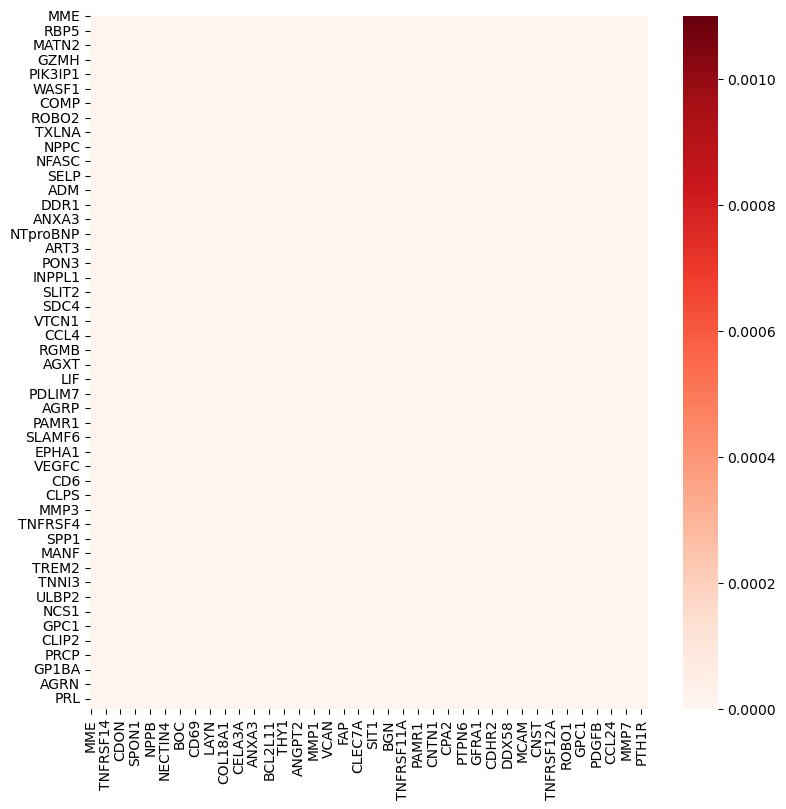

[]


<Figure size 640x480 with 0 Axes>

In [92]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_kNN/CM_BR_kNN_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()

#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/BR_kNN/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

### RakelD

In [93]:
%%time
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD

classifier = RakelD(
    base_classifier=GaussianNB(),
    base_classifier_require_dense=[True, True],
)



classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)
print(hamming_loss(y_test,predictions))

0.2711754068716094
CPU times: user 1.15 s, sys: 38.1 ms, total: 1.19 s
Wall time: 1.28 s


In [94]:
from sklearn.metrics import classification_report

labels = df_train.columns
len(labels)
label_names = labels[:-2]

print(classification_report(y_test, predictions,target_names=label_names,zero_division=1))
#print(classification_report(y_test, previsto,target_names=label_names,zero_division=1))

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1))

              precision    recall  f1-score   support

         MME       0.00      1.00      0.00         0
      ADAM15       1.00      1.00      1.00         0
       RTN4R       0.00      1.00      0.00         0
      BTN2A1       1.00      1.00      1.00         0
        SOD2       1.00      1.00      1.00         0
        ROR1       0.00      1.00      0.00         0
         KIT       0.00      1.00      0.00         0
      LRPAP1       0.00      1.00      0.00         0
       CXCL9       1.00      0.00      0.00         1
        CLMP       1.00      1.00      1.00         0
        DSG3       1.00      0.00      0.00         1
        RBP5       1.00      0.00      0.00         1
      SPINK1       0.00      1.00      0.00         0
        CPB1       1.00      1.00      1.00         0
    TNFRSF14       1.00      0.00      0.00         1
       CD276       0.00      1.00      0.00         0
       LAIR1       0.01      1.00      0.01         1
     CEACAM8       0.01    

0.001744563453424213
0.36820340890326764
0.002076368797216371
0.0019079735545991037
[[[ 18 140]
  [  0   0]]

 [[158   0]
  [  0   0]]

 [[ 18 140]
  [  0   0]]

 ...

 [[157   0]
  [  1   0]]

 [[158   0]
  [  0   0]]

 [[157   0]
  [  1   0]]]
<class 'scipy.sparse._csr.csr_matrix'>
525
[16, 17, 26, 30, 31, 55, 61, 67, 87, 90, 91, 107, 127, 136, 177, 184, 203, 221, 224, 232, 235, 237, 256, 264, 267, 270, 275, 301, 303, 304, 322, 324, 334, 394, 408, 412, 422, 427, 428, 440, 450, 477, 479]
LAIR1
CEACAM8
ACP5
SPON2
NECTIN2
WASF1
SIRPA
EGFL7
SEMA4D
THBD
ADAM22
ERBB2
ARHGAP25
CNTN5
TNFSF11
CD300C
VSIR
CHRDL2
VCAN
ENPP5
CLEC11A
VASN
ADAM23
AGXT
LCN2
PAPPA
LIF
TNFRSF21
DPT
GPNMB
CNTN1
ANGPTL7
FETUB
MFAP5
ACVRL1
APP
CCN3
DCBLD2
ICAM1
ULBP2
IFNGR1
LAT
HAO1


Model Proportion        HL      Prec       Rec  \
0                           MLKNN      70_30  0.001905  1.000000  0.714286   
0                           HARAM      70_30  0.006920  0.855238  0.714286   
0                BR_MultinomialNB      70_30  0.001905  1.000000  0.714286   
0  Label Powerset GradientBooster      70_30  0.003785  0.992393  0.716190   
0                 ClassifierChain      70_30  0.003810  0.992381  0.714286   

         F1       Jac  
0  0.714286  0.714286  
0  0.607619  0.607619  
0  0.714286  0.714286  
0  0.708596  0.708584  
0  0.712381  0.712381

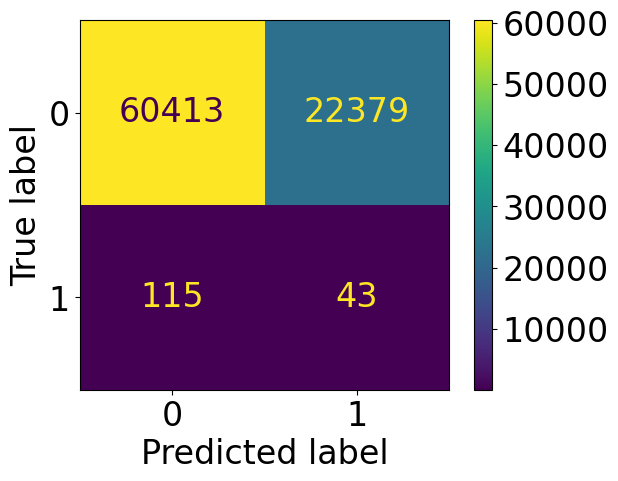

<Figure size 640x480 with 0 Axes>

In [95]:
from sklearn.metrics import jaccard_score
print(jaccard_score(predictions.A,y_test, average='samples', zero_division=True))
print(jaccard_score(y_test,predictions.A, average='macro',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='weighted',zero_division=True))
print(jaccard_score(y_test,predictions.A, average='micro',zero_division=True))

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(multilabel_confusion_matrix(y_test, predictions.A))


matrices = multilabel_confusion_matrix(y_test, predictions)

print(type(y_test))

cm = confusion_matrix(y_test.A.ravel(), predictions.A.ravel())
plt.rcParams.update({'font.size': 24})
# Create a ConfusionMatrixDisplay object
#cmd = ConfusionMatrixDisplay(cm, display_labels=[f"Class {i}" for i in range(2)])
cmd = ConfusionMatrixDisplay.from_predictions(y_test.A.ravel(), predictions.A.ravel(),values_format='')
# Display the confusion matrix
cmd.plot()
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RakelD/CM_RakelD_" + split_factor_file_train + "_flattened.eps", transparent=True, format='png',bbox_inches = 'tight')
plt.rcParams.update({'font.size': 10})
plt.clf()

num_classes = len(matrices)
print(num_classes)
# Initialize an empty list to store the true positive row indices
tp_indices = []

# Iterate over each class
for i in range(num_classes):
    # Get the confusion matrix for the current class
    class_cm = matrices[i]
    #print(class_cm.shape)
    
    # Extract the true positive count from the confusion matrix
    tp = class_cm[1, 1]
    
    # If the true positive count is greater than 0, add the index to the list
    if tp > 0:
        tp_indices.append(i)


#rows que testaram true positive        
print(tp_indices)
proteins_confusion_matrix_flattened = []
if (len(tp_indices)>0):
    for i in tp_indices:
        print(df_train.columns[i])
        proteins_confusion_matrix_flattened.append(df_train.columns[i])
    pd.DataFrame(proteins_confusion_matrix_flattened).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RakelD/true_positive_proteins__flattened_BMI_Age_" + split_factor_file_train + ".csv") 
 

#define rows to add
rows_to_append = pd.DataFrame([{'Model':'RakelD', 'Proportion':split_factor_file_train, 
                                'HL':hamming_loss(y_test, predictions),
                               'Prec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[0],
                               'Rec':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[1],
                               'F1':precision_recall_fscore_support(y_test, predictions, average='macro',zero_division=1)[2],
                               'Jac':jaccard_score(y_test,predictions, average='macro',zero_division=True)}])
                           

#add row to empty DataFrame
df_model_scores = pd.concat([df_model_scores, rows_to_append])

df_model_scores.head()

(158, 525)
(158, 525)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
M is  (525, 525)
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente d

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  0 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|Yi\Zi| =  1 , shape =  (525,)
|Zi\Yi| =  46 , shape =  (525,)
condiçao |Zi\Yi| diferente de 0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0.

precision_M =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


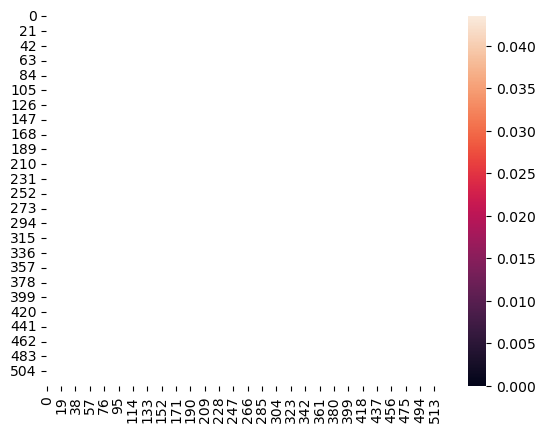

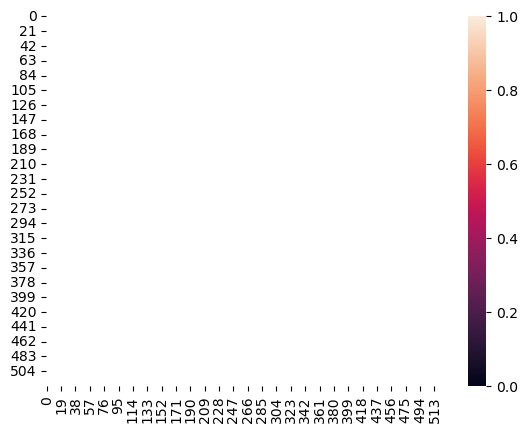

In [96]:
#y_test is already ndarray
Z = predictions.A
print(Z.shape)
Y = y_test.A
print(Y.shape)
M = confusion_matrix_article(Y,Z)
precision_M = precision_matrix(M)

ax = sns.heatmap(M, linewidth=0.5)
plt.show()

ax = sns.heatmap(precision_M, linewidth=0.5)
plt.show()

### Confusion Matrix Article

Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.0 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.007832111657796952 . Min value:  0.0
Max value:  0.

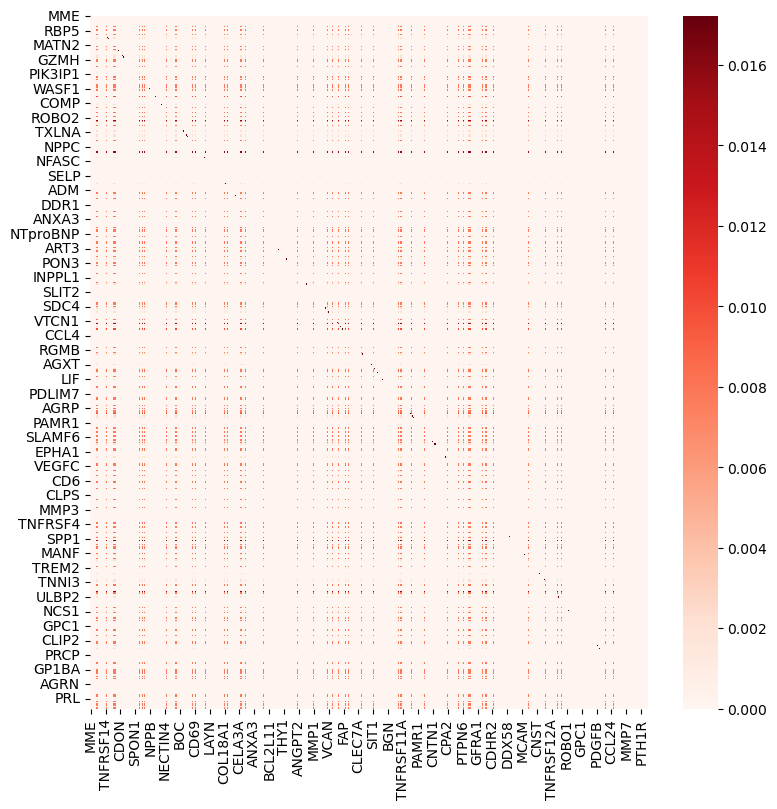

[8, 10, 11, 14, 16, 17, 23, 25, 26, 30, 31, 33, 34, 38, 46, 48, 52, 53, 54, 55, 56, 61, 67, 69, 73, 76, 79, 80, 83, 87, 90, 91, 94, 103, 107, 127, 134, 136, 138, 148, 152, 160, 162, 163, 167, 171, 172, 175, 177, 178, 182, 184, 187, 189, 195, 202, 203, 217, 218, 220, 221, 224, 230, 232, 233, 235, 237, 251, 255, 256, 264, 267, 268, 269, 270, 273, 275, 281, 289, 290, 295, 297, 299, 300, 301, 303, 304, 312, 315, 318, 321, 322, 323, 324, 328, 329, 334, 339, 340, 344, 348, 353, 358, 366, 372, 384, 387, 391, 394, 395, 397, 400, 402, 403, 407, 408, 411, 412, 417, 422, 427, 428, 431, 436, 437, 440, 448, 450, 452, 456, 458, 465, 469, 474, 475, 477, 479, 490, 495, 496, 497, 498, 500, 502, 514, 515, 519, 521, 522, 524]
CXCL9
DSG3
RBP5
TNFRSF14
LAIR1
CEACAM8
KITLG
CCDC80
ACP5
SPON2
NECTIN2
GZMH
PRSS8
NTRK2
FCN2
TIA1
SPINT2
DRAXIN
CXCL10
WASF1
NPPB
SIRPA
EGFL7
HSPG2
FKBP1B
ITGA11
KLK11
CCL23
ACTN4
SEMA4D
THBD
ADAM22
COX5B
ADAMTS15
ERBB2
ARHGAP25
TGFA
CNTN5
MMP10
CD209
ADAMTS16
YES1
CXCL16
HYOU1
TNFS

<Figure size 640x480 with 0 Axes>

In [97]:
max_value = np.float64(0)
min_value = np.float64(0)


tp_indices_article = []


for row in range(0,len(precision_M)):
    #max_value = np.float64(max(precision_M[row,:]))
    
    
    #if(max(precision_M[row,:])>0):
    #    print(max(precision_M[row,:]>0))
    #else:
    #    print(max(precision_M[row,:]>0))
    if(max(precision_M[row,:])>0):
        tp_indices_article.append(row)
     
    if(max(precision_M[row,:])>max_value):
        if(max(precision_M[row,:])<1):
            max_value = np.float64(max(precision_M[row,:]))
            
    
    if(min(precision_M[row,:])>min_value):
        min_value = np.float64(min(precision_M[row,:]))
        
    print("Max value: ", max_value, ". Min value: ",min_value) 
    

if(max_value==0):
    max_value = np.float64(0.001)
    
    
plt.figure(figsize = (9,9))   
df_precision_M = pd.DataFrame(precision_M, columns = df_train.iloc[:,:-2].columns, index = df_train.iloc[:,:-2].columns )
df_precision_M
ax = sns.heatmap(df_precision_M,vmin=min_value, vmax=max_value*1.1, cmap="Reds")
plt.savefig("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RakelD/CM_RakelD_" + split_factor_file_train + "_article.eps", transparent=True, format='png')

plt.show()
plt.clf()


#rows que testaram true positive    
proteins_confusion_matrix_article = []
print(tp_indices_article)
if (len(tp_indices_article)>0):
    for i in tp_indices_article:
        proteins_confusion_matrix_article.append(df_train.columns[i])
        print(df_train.columns[i])
    proteins_confusion_matrix_article.append(max_value)
    pd.DataFrame(proteins_confusion_matrix_article).to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/RakelD/true_positive_proteins_BMI_Age_" + split_factor_file_train + ".csv") 

In [98]:
df_model_scores.to_csv("/Users/marcelo_palermo/Doutorado/R/Olink/NextSteps/Results/BMI_Age/ML Models/Scores_BMI_Age_" + split_factor_file_train + ".csv") 

In [99]:
#exit()